In [18]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import random
from sklearn.model_selection import train_test_split
from sklearn import svm

In [19]:
con = sqlite3.connect(r"../laliga.sqlite")
# Change date format (2029 -> 1929)
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['date'] = pd.to_datetime(df[['day', 'month', 'year']]).dt.strftime('%d/%m/%Y') 

# We also change the formatting of the time to be in 24h format
df['time'] = df['time'].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)

df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df2=df.dropna(subset = "score")
df2["goal diff"] = (df2["home_goals"]  - df2["away_goals"])
df2["results"] = np.where(df2["goal diff"] > 0, "1", np.where(df2["goal diff"] < 0, "2", "X"))
df2.head()



,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results
0,1928-1929,1,1,10/02/1929,None,Arenas Club,Athletic Madrid,2:3,2,10,1929,2.0,3.0,-1.0,2
1,1928-1929,1,1,10/02/1929,None,Espanyol,Real Unión,3:2,2,10,1929,3.0,2.0,1.0,1
2,1928-1929,1,1,10/02/1929,None,Real Madrid,Catalunya,5:0,2,10,1929,5.0,0.0,5.0,1
3,1928-1929,1,1,10/02/1929,None,Donostia,Athletic,1:1,2,10,1929,1.0,1.0,0.0,X
4,1928-1929,1,1,12/02/1929,None,Racing,Barcelona,0:2,2,12,1929,0.0,2.0,-2.0,2


Features:
1. Home (1) vs. Visitor (0)
2. Sum goals
3. Sum received goals (conceed)
4. Diff 2&3
5. Ratio of head-to-head won games.
6. Season percentage (0-1). A qué altura de la temporada estamos (0 inicio, 1 final). 
7. Number of points during the season.
8. Absolute rankings.
9. Time of game (0-24).

In [20]:
#1
df2['home_win'] = df['home_goals'] > df['away_goals']
#2
df2['total_goals_sum'] = 0
pd.crosstab(df2['home_team'], df2['total_goals_sum'], df2['home_goals'], aggfunc=sum)

total_goals_sum,0
home_team,
AD Almería,50.0
Alavés,936.0
Albacete,688.0
Alcorcón,290.0
Algeciras CF,67.0
...,...
Valencia,3046.0
Villarreal,905.0
Villarreal CF B,89.0


In [21]:
list_teams = df2["home_team"].unique()
dict_teams = {}
counter = 0
for team in list_teams:
    dict_teams[team] = counter
    counter += 1

df2["num_home"] = df["home_team"].apply(lambda x: dict_teams[x])
df2["num_away"] = df["away_team"].apply(lambda x: dict_teams[x])

In [22]:
y = df2.results
x = df2[["num_home", "num_away", "home_win"]]

#x = data.drop('temp',axis=1)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [23]:
clf = svm.SVC()
clf.fit(x_train, y_train)

SVC()

In [24]:
y_pred = clf.predict(x_test)

In [25]:
y_pred

array(['1', 'X', 'X', ..., 'X', 'X', 'X'], dtype=object)

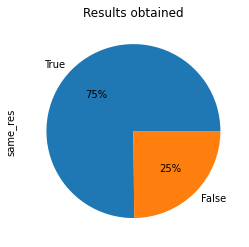

In [26]:
results = pd.DataFrame({"y_test": y_test})
results["y_pred"] = y_pred
results["same_res"]  = results["y_test"] == results["y_pred"]

prediction_results = results["same_res"].value_counts()
ax = prediction_results.plot(kind = 'pie', autopct = '%1.0f%%')
ax.set_title("Results obtained")
plt.show()

In [27]:
by_season = df2.groupby(df2["season"])

def df_generator(start, end):
    seasons = []

    for i in range(end - start):
        season = "{}-{}".format(start + i, start + i + 1)
        seasons.append(season)
    
    append_data = []
    for season in seasons:
        append_data.append(by_season.get_group(season))
    complete_dataframe = pd.concat(append_data)
    return(complete_dataframe)

In [28]:
train_df = df_generator(2010, 2020)
test_season = "2021-2022"
matchday = 3
division = 1

test_df = by_season.get_group(test_season).loc[(df2["matchday"] == matchday) & (df2["division"] == division)]
test_df

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win,total_goals_sum,num_home,num_away
48198,2021-2022,1,3,27/08/2021,20:00,RCD Mallorca,Espanyol,1:0,8,27,2021,1.0,0.0,1.0,1,True,0,40,1
48199,2021-2022,1,3,27/08/2021,22:15,Valencia,Alavés,3:0,8,27,2021,3.0,0.0,3.0,1,True,0,11,10
48200,2021-2022,1,3,28/08/2021,17:00,Celta de Vigo,Athletic,0:1,8,28,2021,0.0,1.0,-1.0,2,False,0,18,6
48201,2021-2022,1,3,28/08/2021,19:30,Real Sociedad,Levante,1:0,8,28,2021,1.0,0.0,1.0,1,True,0,24,44
48202,2021-2022,1,3,28/08/2021,19:30,Elche CF,Sevilla FC,1:1,8,28,2021,1.0,1.0,0.0,X,False,0,39,14
48203,2021-2022,1,3,28/08/2021,22:00,Real Betis,Real Madrid,0:1,8,28,2021,0.0,1.0,-1.0,2,False,0,12,2
48204,2021-2022,1,3,29/08/2021,17:00,Barcelona,Getafe,2:1,8,29,2021,2.0,1.0,1.0,1,True,0,5,61
48205,2021-2022,1,3,29/08/2021,19:30,Cádiz CF,CA Osasuna,2:3,8,29,2021,2.0,3.0,-1.0,2,False,0,48,16
48206,2021-2022,1,3,29/08/2021,19:30,Rayo Vallecano,Granada CF,4:0,8,29,2021,4.0,0.0,4.0,1,True,0,49,22
48207,2021-2022,1,3,29/08/2021,22:00,Atlético Madrid,Villarreal,2:2,8,29,2021,2.0,2.0,0.0,X,False,0,30,58


In [29]:
x_train = train_df[["num_home", "num_away", "home_win"]]
x_test = test_df[["num_home", "num_away", "home_win"]]

y_train = train_df.results
y_test = test_df.results

In [30]:
clf = svm.SVC()
clf.fit(x_train, y_train)

SVC()

In [31]:
y_pred = clf.predict(x_test)

In [32]:
y_pred

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], dtype=object)

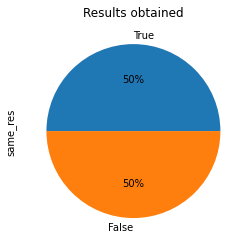

In [33]:
results = pd.DataFrame({"y_test": y_test})
results["y_pred"] = y_pred
results["same_res"]  = results["y_test"] == results["y_pred"]

prediction_results = results["same_res"].value_counts()
ax = prediction_results.plot(kind = 'pie', autopct = '%1.0f%%')
ax.set_title("Results obtained")
plt.show()

In [34]:
import pickle


class QuinielaModel:

    def train(self, train_data):
        # Do something here to train the model
        pass

    def predict(self, predict_data):
        # Do something here to predict
        return ["X" for _ in range(len(predict_data))]